[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/idealo/image-super-resolution/blob/master/notebooks/ISR_Prediction_Tutorial.ipynb)

# Install ISR

In [1]:
!pip install ISR

     |████████████████████████████████| 17.3MB 56.3MB/s 
     |████████████████████████████████| 92.5MB 49.9MB/s 
     |████████████████████████████████| 3.2MB 38.1MB/s 
     |████████████████████████████████| 368kB 55.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow

# Predict

## Get the pre-trained weights and data

(for more options on getting you data on Colab notebooks visit https://colab.research.google.com/notebooks/io.ipynb)

Get the weights with



In [2]:
!wget https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2/ArtefactCancelling/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5
!wget https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2/PSNR-driven/rdn-C6-D20-G64-G064-x2_PSNR_epoch086.hdf5
!wget https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C3-D10-G64-G064-x2/PSNR-driven/rdn-C3-D10-G64-G064-x2_PSNR_epoch134.hdf5
!mkdir weights
!mv *.hdf5 weights

--2019-08-05 12:09:14--  https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2/ArtefactCancelling/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/idealo/image-super-resolution/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2/ArtefactCancelling/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5 [following]
--2019-08-05 12:09:15--  https://media.githubusercontent.com/media/idealo/image-super-resolution/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2/ArtefactCancelling/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githu

Download a sample image, in this case

In [0]:
import os
#!pwd
#!wget http://images.math.cnrs.fr/IMG/png/section8-image.png
source_url = 'https://i.imgur.com/BfLZbra.jpg' #@param {type:"string"}
os.system('wget %s' %source_url)
filename = source_url[source_url.rfind("/")+1:]
os.rename(filename, 'section8-image.jpg')

!mkdir -p data/input/test_images
!mv section8-image.jpg data/input/test_images

Load the image with PIL

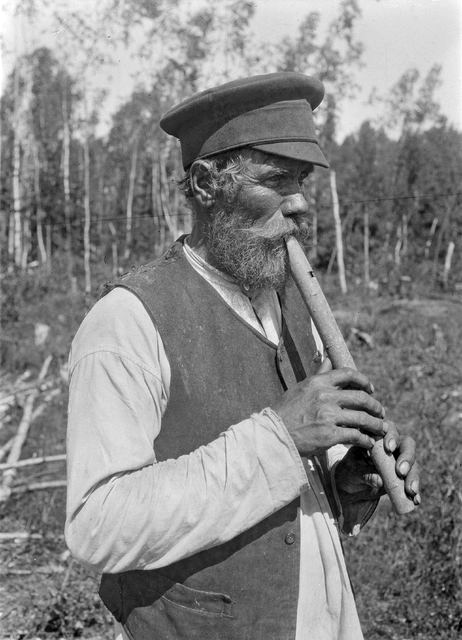

In [31]:
import numpy as np
from PIL import Image

img = Image.open('data/input/test_images/section8-image.jpg')
img

## Get predictions

### Create the model and run prediction
Create the RDN model, for which we provide pre-trained weights, and load them

Choose amongst the available model weights, compare the output if you wish.



In [0]:
from ISR.models import RDN

#### Large RDN model

In [0]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_PSNR_epoch086.hdf5')

#### Small RDN model

In [0]:
rdn = RDN(arch_params={'C': 3, 'D':10, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C3-D10-G64-G064-x2_PSNR_epoch134.hdf5')

#### Large RDN noise cancelling, detail enchancing model

In [0]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5')

#### Run prediction

In [36]:
sr_img = rdn.predict(np.array(img))
Image.fromarray(sr_img)

Output hidden; open in https://colab.research.google.com to view.

### Usecase: upscaling noisy images

Now, for science, let's make it harder for the networks.

We compress the image into the jpeg format to introduce compression artefact and lose some information.

We will compare:
- the baseline bicubic scaling
- the basic model - Add Hyperlink
- a model trained to remove noise using perceptual loss with deep features and GANs training

So let's first  compress the image

In [0]:
img.save('data/input/test_images/compressed.jpeg','JPEG', dpi=[300, 300], quality=50)
compressed_img = Image.open('data/input/test_images/compressed.jpeg')

compressed_img

(open the image in a new tab and zoom in to inspect it)

#### Baseline
Bicubic scaling

In [0]:
compressed_img.resize(size=(compressed_img.size[0]*2, compressed_img.size[1]*2), resample=Image.BICUBIC)

#### Large RDN model (PSNR trained)

In [0]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_PSNR_epoch086.hdf5')
sr_img = rdn.predict(np.array(compressed_img))
Image.fromarray(sr_img)

#### Small RDN model  (PSNR trained)

In [0]:
rdn = RDN(arch_params={'C': 3, 'D':10, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C3-D10-G64-G064-x2_PSNR_epoch134.hdf5')
sr_img = rdn.predict(np.array(compressed_img))
Image.fromarray(sr_img)

#### Large RDN noise cancelling, detail enhancing model

In [0]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5')
sr_img = rdn.predict(np.array(compressed_img))
Image.fromarray(sr_img)

### Predictor Class
You can also use the predictor class to run the model on entire folders:

In [0]:
from ISR.predict import Predictor
!mkdir -p data/output
predictor = Predictor(input_dir='data/input/test_images/')
predictor.get_predictions(model=rdn, weights_path='weights/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5')